In [23]:

from typing import Dict

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt

from src.spectrogram import Spectrogram, split_spectrogram
from src.spectrum_painting import take_frequencies, downsample_spectrogram, augment_spectrogram, paint_spectrogram, \
    digitize_spectrogram


In [24]:
def convert_complex_numbers(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Convert complex numbers strings where 'i' (Math convention) is used to use 'j' (Engineering convention) instead
    and convert it to numpy complex number type.
    :param frame: A Pandas dataframe
    :return: A data frame containing numpy complex numbers.
    """
    return frame.map(lambda row: np.csingle(row.replace("i", "j")))[0]


# Read the data where b = Bluetooth, w = WiFi, z = Zigbee. So the frame
# called 'zb' means it is the spectrogram containing Zigbee and Bluetooth
# signals.
data_frames: Dict[str, pd.DataFrame] = {
    "b": pd.read_csv("data/csv/B_SNR30.csv", sep=",", header=None, dtype=str),
    "bw": pd.read_csv("data/csv/BW_SNR30.csv", sep=",", header=None, dtype=str),
    "w": pd.read_csv("data/csv/W_SNR30.csv", sep=",", header=None, dtype=str),
    "z": pd.read_csv("data/csv/Z_SNR30.csv", sep=",", header=None, dtype=str),
    "zb": pd.read_csv("data/csv/ZB_SNR30.csv", sep=",", header=None, dtype=str),
    "zw": pd.read_csv("data/csv/ZW_SNR30.csv", sep=",", header=None, dtype=str),
    "zbw": pd.read_csv("data/csv/ZBW_SNR30.csv", sep=",", header=None, dtype=str)
}

# Convert complex number notation
data_frames = {key: convert_complex_numbers(frame) for key, frame in data_frames.items()}

In [25]:
def plot_spectrogram(spectrogram: Spectrogram):
    plt.pcolormesh(spectrogram.f, spectrogram.t, spectrogram.values.T, shading="nearest")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Time (s)")
    plt.title("Spectrogram")
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

Number of training images: 49


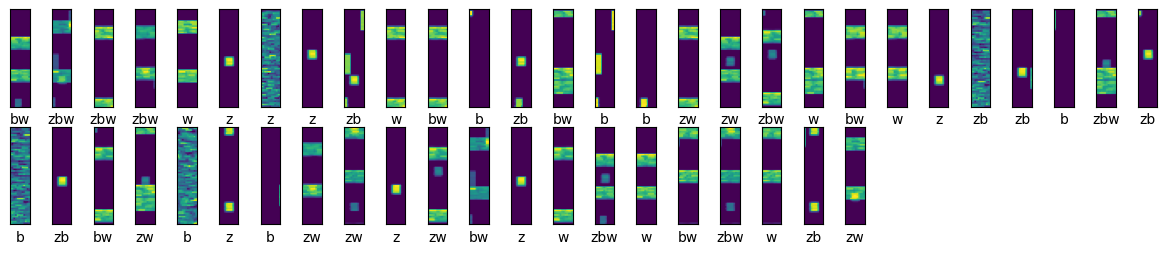

In [31]:
from src.spectrogram import create_spectrogram

# Sampling frequency
fs = 20000000  # 20MHz

spectrograms: Dict[str, Spectrogram] = {key: create_spectrogram(frame, fs) for key, frame in data_frames.items()}

np.random.seed(42)

training_data: list[(str, npt.NDArray[int])] = []

downsample_resolution = 60

K = 3
L = 16
D = 4

for (label, spec) in spectrograms.items():
    middle: int = len(spec.values) // 2
    start_freq: int = middle - 30
    end_freq: int = middle + 30

    spec = take_frequencies(spec, start_freq, end_freq)

    slices = split_spectrogram(spec, duration=1000)

    downsampled_slices = [downsample_spectrogram(s.values, downsample_resolution) for s in slices]
    augmented_slices = [augment_spectrogram(s, K, L, D) for s in downsampled_slices]

    painted_slices = [paint_spectrogram(original, augmented) for (original, augmented) in
                      list(zip(downsampled_slices, augmented_slices))]

    digitized_slices = [digitize_spectrogram(s, 256) for s in augmented_slices]

    for s in digitized_slices:
        training_data.append((label, s))

np.random.shuffle(training_data)

print(f"Number of training images: {len(training_data)}")

plt.figure(figsize=(15, 15))
for i in range(len(training_data)):
    (label, image) = training_data[i]
    plt.subplot(10, 28, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()